In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
#leemos la informacion censal de poblacion por radio
radios = gpd.read_file('data/informacion_censal_por_radio_2010.shp')
#calculamos la densidad poblaciona l como parametro de interes
radios['densidad'] = radios.TOTAL_POB / (radios.geometry.area / 1000)
#seleccionamos los atributos de interes
radios = radios.reindex(columns=[ 'CO_FRAC_RA', 'COMUNA','TOTAL_POB','densidad','geometry'])
radios.to_file('radios')

In [3]:
#leemos los rios solamente como vector para visualizacion
rios = gpd.read_file('data/rios.shp')
#le asignamos la proyeccion de nuestros radios
rios = rios.to_crs(radios.crs)


In [4]:
from shapely import wkt
#leemos la informacion de parques publicos desde un csv con Well Known Text (WKT)
parques = pd.read_csv('data/espacio-verde-publico.csv')
parques['geometry'] = parques.WKT.apply(wkt.loads)
crs = {'init' :'epsg:4326'}
#a partir del csv y data frame, convertimos en GeoDataFramse con un crs
parques = gpd.GeoDataFrame(parques, geometry='geometry',crs=crs)
parques = parques.reindex(columns= ['nombre','area','geometry'])
parques = parques.to_crs(radios.crs)
parques.to_file('parques')

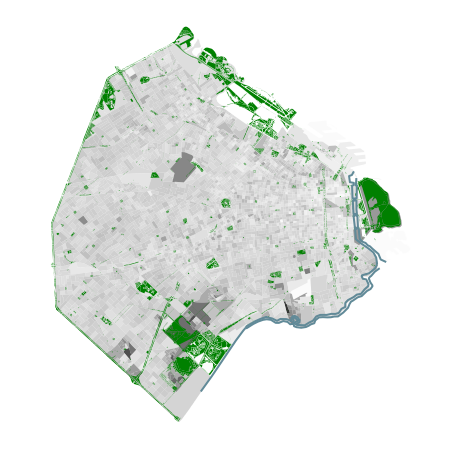

In [5]:
#ploteamos un mapa basico de nuestros datos
f, ax = plt.subplots(1,figsize=(8,8))
radios.plot(column = 'TOTAL_POB',cmap='binary',ax=ax, alpha = 0.8,linewidth=0.1)
rios.plot(ax=ax, color='#618A98',linewidth=2)
parques.plot(ax=ax, color='green')
plt.axis('equal')
ax.set_axis_off()

In [ ]:
#f, ax = plt.subplots(1,figsize=(8,8))
#radios.plot(column = 'TOTAL_POB',cmap='binary',ax=ax, alpha = 0.8),markersize = radios.TOTAL_POB/100)
#rios.plot(ax=ax, color='#618A98',linewidth=2)
#parques.plot(ax=ax, color='darkgreen',markersize = parques.loc[:,'area']/2000)
#plt.axis('equal')
#ax.set_axis_off()
#plt.show()

In [6]:
#ciertos procesos geograficos se realizan sobre puntos, no sobre poligonos
#creamos geodataframes con geometrias tipo punto a partir de los centroides

radios_p = radios.copy()
radios_p.geometry = radios_p.geometry.centroid

parques_p = parques.copy() 
parques_p.geometry = parques_p.geometry.centroid

In [7]:
#importamos el objeto geografico multipoint
from shapely.geometry import MultiPoint
#impotamos la operacion geografica que permite ver los puntos mas cercanos
from shapely.ops import nearest_points

#generamos un objeto MultiPoint que contenga todos los puntos-centroides de parques
parques_multi = MultiPoint([i for i in parques_p.geometry])

def distancia_mas_cercano(geom,parques = parques_multi):
    par = nearest_points(geom,parques)
    return par[0].distance(par[1])


In [8]:
#creamos la columna distancia en ambos datasets
radios['distancia'] = radios_p.geometry.map(distancia_mas_cercano)
radios_p['distancia'] = radios_p.geometry.map(distancia_mas_cercano)

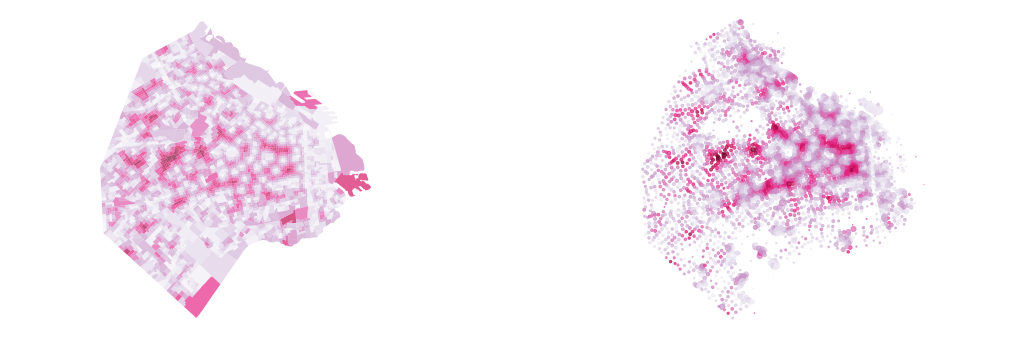

In [9]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(1,2,1) 
ax2 = fig.add_subplot(1,2,2)

radios.plot(column = 'distancia',cmap='PuRd',ax=ax1, alpha = 0.7)
radios_p.plot(column = 'distancia',cmap='PuRd',ax=ax2, alpha = 0.7,markersize = radios.densidad**0.8)
ax1.axis('equal')
ax2.axis('equal')

ax1.set_axis_off()
ax2.set_axis_off()

In [10]:
#import mplleaflet

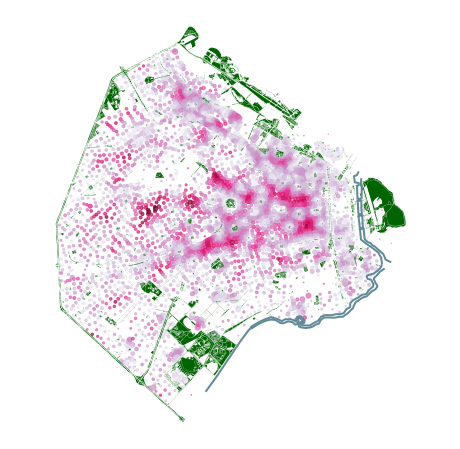

In [11]:
f, ax = plt.subplots(1,figsize=(8,8))
radios_p.plot(column = 'distancia',cmap='PuRd',ax=ax, alpha = 0.7,markersize = radios_p.densidad**0.8)
rios.plot(ax=ax, color='#618A98',linewidth=2)
parques.plot(ax=ax, color='darkgreen',markersize = parques.loc[:,'area']/2000)
plt.axis('equal')
ax.set_axis_off()
f.savefig('mapa_densidad_distancia.png')

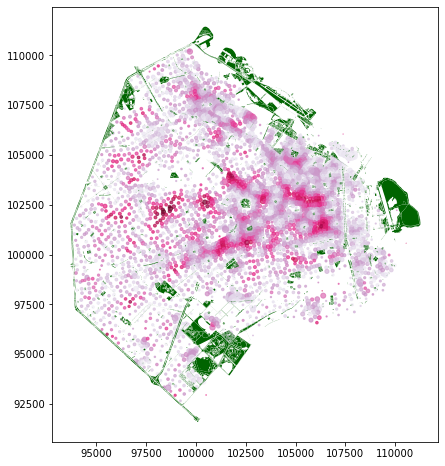

In [12]:
f, ax = plt.subplots(1,figsize=(8,8))
radios_p.plot(column = 'distancia',cmap='PuRd',ax=ax, alpha = 0.7,markersize = radios_p.densidad**0.8)
parques.plot(ax=ax, color='darkgreen',markersize = parques.loc[:,'area']/2000)
#mplleaflet.show(fig=ax.figure, crs=radios.crs, tiles='cartodb_positron', path='puntos_distancia_pob.html')
plt.show()

In [13]:
def pob_a_distancia(minutos,radios=radios_p):
    #velocidad de caminata 5km/h
    metros = minutos*5/60*1000
    radios['metros'] = radios.distancia <= metros
    tabla = radios.loc[:,['metros','TOTAL_POB']].groupby('metros').sum()
    return round(tabla['TOTAL_POB'][True] / tabla['TOTAL_POB'].sum()* 100)

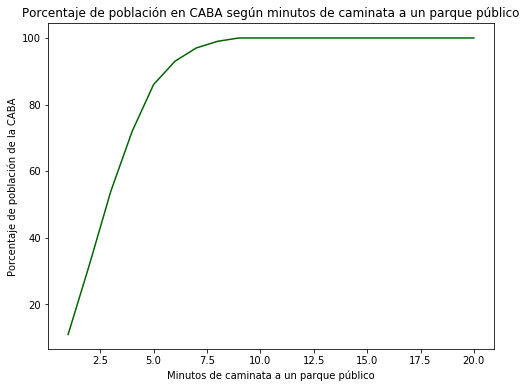

In [14]:
minutos = range(1,21)
prop = [pob_a_distancia(minuto) for minuto in minutos]
f, ax = plt.subplots(1,figsize=(8,6))

ax.plot(minutos,prop,'darkgreen')
ax.set_title('Porcentaje de población en CABA según minutos de caminata a un parque público')
ax.set_xlabel('Minutos de caminata a un parque público')
ax.set_ylabel('Porcentaje de población de la CABA')
f.savefig('porcentajeXminutos.png')

In [15]:
def pob_a_distancia_area(area, minutos = 5,radios=radios_p):
    
    parques_multi = MultiPoint([i for i in parques_p.loc[parques_p.loc[:,'area'] > area,'geometry']])
    
    def distancia_mas_cercano(geom,parques = parques_multi):
        par = nearest_points(geom,parques)
        return par[0].distance(par[1])

    radios['distancia'] = radios.geometry.map(distancia_mas_cercano)
    #velocidad de caminata 5km/h
    metros = minutos*5/60*1000
    radios['metros'] = radios.distancia <= metros
    tabla = radios.loc[:,['metros','TOTAL_POB']].groupby('metros').sum()
    return round(tabla['TOTAL_POB'][True] / tabla['TOTAL_POB'].sum()* 100)

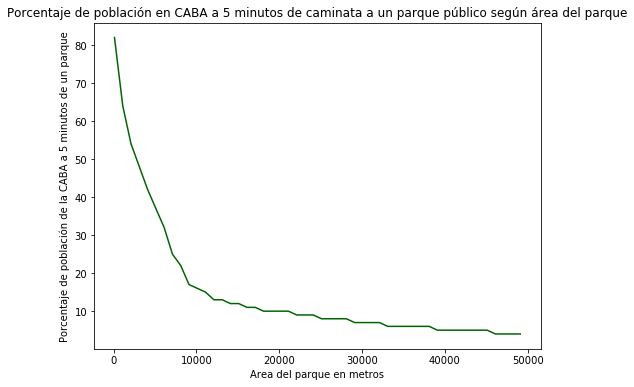

In [50]:
areas = range(100,50000,1000)
prop = [pob_a_distancia_area(area) for area in areas]



In [125]:
lezama = parques_data.loc[parques_data.nombre.map(lambda n: 'Lezama' in n),:]
boedo = parques_data.loc[parques_data.nombre.map(lambda n: 'Boedo' in n),:]
barrancas = parques_data.loc[parques_data.nombre.map(lambda n: 'Barrancas de Belgrano' in n),:]
almagro = parques_data.loc[parques_data.nombre.map(lambda n: 'Almagro' in n),:]
irlanda = parques_data.loc[parques_data.nombre.map(lambda n: 'Irlanda' in n),:]
belgica = parques_data.loc[parques_data.nombre.map(lambda n: 'Plaza Bélgica' in n),:]
vera = parques_data.loc[parques_data.nombre.map(lambda n: 'Pza. Rosario Vera Peñaloza' in n),:]

In [126]:
barrancas = (barrancas['area'].item(),pob_a_distancia_area(barrancas['area'].item()))
boedo = (boedo['area'].item(),pob_a_distancia_area(boedo['area'].item()))
lezama = (lezama['area'].item(),pob_a_distancia_area(lezama['area'].item()))
almagro = (almagro['area'].item(),pob_a_distancia_area(almagro['area'].item()))
irlanda = (irlanda['area'].item(),pob_a_distancia_area(irlanda['area'].item()))
belgica = (belgica['area'].item(),pob_a_distancia_area(belgica['area'].item()))
vera = (vera['area'].item(),pob_a_distancia_area(vera['area'].item()))



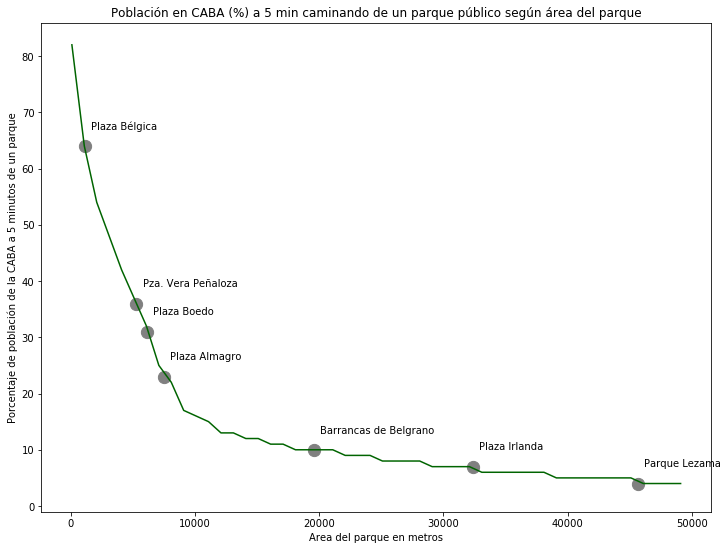

In [128]:
f, ax = plt.subplots(1,figsize=(12,9))

ax.plot(areas,prop,'darkgreen')
ax.scatter([barrancas[0],boedo[0],lezama[0],almagro[0],irlanda[0],belgica[0],vera[0]],
           [barrancas[1],boedo[1],lezama[1],almagro[1],irlanda[1],belgica[1],vera[1]],
           s=150,color='grey')

ax.set_title('Población en CABA (%) a 5 min caminando de un parque público según área del parque')
ax.set_xlabel('Area del parque en metros')
ax.set_ylabel('Porcentaje de población de la CABA a 5 minutos de un parque')

ax.annotate('Barrancas de Belgrano', xy=(barrancas[0] + 500, barrancas[1] + 3))
ax.annotate('Plaza Boedo', xy=(boedo[0] + 500, boedo[1] + 3))
ax.annotate('Parque Lezama', xy=(lezama[0] + 500, lezama[1] + 3))
ax.annotate('Plaza Almagro', xy=(almagro[0] + 500, almagro[1] + 3))
ax.annotate('Plaza Irlanda', xy=(irlanda[0] + 500, irlanda[1] + 3))
ax.annotate('Plaza Bélgica', xy=(belgica[0] + 500, belgica[1] + 3))
ax.annotate('Pza. Vera Peñaloza', xy=(vera[0] + 500, vera[1] + 3))

f.savefig('porcentajeXarea.png')

In [124]:
parques_data.loc[(parques_data['area'] > 5000) & (parques_data['area'] < 5500),:]

,nombre,ubicacion,clasificac,area,geometry
112,Islas Canarias,"RABANAL, FRANCISCO, INT., AV. (EX ROCA, CNEL.,...",CANTERO CENTRAL,5171.534,(POLYGON ((-58.4230614189927 -34.6570075961773...
164,Pza. J. J. Paso,"OLAGUER Y FELIU, VIRREY - MOLDES - ZABALA - VI...",PLAZA,5452.254,(POLYGON ((-58.4532977075362 -34.5697420555148...
219,,"ROCA, CNEL., AV. E/ PORTELA Y PAZ, GRAL., AV ...",CANTERO CENTRAL,5364.749,(POLYGON ((-58.4495791343941 -34.6791992035966...
310,,"DELLEPIANE, LUIS J., TTE. GRAL., AV. E/ PAZ, G...",CANTERO CENTRAL,5364.042,(POLYGON ((-58.4810702936563 -34.6816654681195...
321,,"DELLEPIANE, LUIS J., TTE. GRAL., AV. E/ PAZ, G...",CANTERO CENTRAL,5347.472,"(POLYGON ((-58.4838166120249 -34.687209830366,..."
440,Doña Petrona C. de Gandulfo,HOLMBERG - NUÑEZ - DONADO - MANUELA PEDRAZA,PLAZOLETA,5263.023,"(POLYGON ((-58.484689613442 -34.560060925238, ..."
448,Hidroavión Buenos Aires,"OBLIGADO, RAFAEL AV. COSTANERA (FRENTE AL AERO...",CANTERO CENTRAL,5091.860,(POLYGON ((-58.4105950968161 -34.5575230995998...
539,Pza. Nicaragua,"PEPIRI - PAZ, JOSE C. - ELIA",PLAZA,5441.659,(POLYGON ((-58.4088137881036 -34.6455605939003...
816,Pza. Leandro N. Alem,"LARSEN - ARTIGAS - COCHRANE - BUFANO, ALFREDO R.",PLAZA,5385.557,"(POLYGON ((-58.5032453889425 -34.57653972578, ..."
829,Paseo Rep. de Filipinas,"DE LOS INCAS, AV. E/ CRAMER Y ALVAREZ THOMAS,...",JARDÍN,5256.695,(POLYGON ((-58.4693218762016 -34.5785080019447...


In [23]:
parques_data = pd.read_csv('data/espacio-verde-publico.csv')
parques_data['geometry'] = parques_data.WKT.apply(wkt.loads)
crs = {'init' :'epsg:4326'}
#a partir del csv y data frame, convertimos en GeoDataFramse con un crs
parques_data = gpd.GeoDataFrame(parques_data, geometry='geometry',crs=crs)
parques_data = parques_data.reindex(columns= ['nombre','ubicacion','clasificac','area','geometry'])
parques_data.head()

,nombre,ubicacion,clasificac,area,geometry
0,Escuela Scalabrini Ortiz,"CONDE - MATIENZO, BENJAMIN, TTE. - FREIRE, RAM...",PLAZOLETA,1658.266,(POLYGON ((-58.4453556017045 -34.5792487371894...
1,NaN,"CONDE - MATIENZO, BENJAMIN, TTE. - FREIRE, RAM...",PLAZOLETA,3.984,(POLYGON ((-58.4448145611193 -34.5799103804064...
2,Polideportivo Colegiales,"CONDE - MATIENZO, BENJAMIN, TTE. - FREIRE, RAM...",PARQUE,4686.060,(POLYGON ((-58.4448074253007 -34.5798706723809...
3,NaN,"GUIRALDES, INTENDENTE - ESTACIONAMIENTO - PARQ...",PLAZOLETA,3746.965,(POLYGON ((-58.4382360541145 -34.5461619929708...
4,Pza. Rafael Hernández,"ECHEVERRIA - VUELTA DE OBLIGADO - MOM, POLICARPO",PLAZA,558.986,(POLYGON ((-58.4552876770316 -34.5622323287337...


In [45]:
parques_data.nombre = parques_data.nombre.fillna('')
almagro = parques_data.loc[parques_data.nombre.map(lambda n: 'Almagro' in n),:]
lezama = parques_data.loc[parques_data.nombre.map(lambda n: 'Lezama' in n),:]
boedo = parques_data.loc[parques_data.nombre.map(lambda n: 'Boedo' in n),:]
armenia = parques_data.loc[parques_data.nombre.map(lambda n: 'Inmigrantes' in n),:]

In [49]:
armenia

,nombre,ubicacion,clasificac,area,geometry
1020,Pza. Inmigrantes de Armenia,MALABIA - COSTA RICA - ARMENIA - NICARAGUA,PLAZA,5760.625,(POLYGON ((-58.4251407108397 -34.5887648008799...


/home/pipe/anaconda3/envs/un3/lib/python3.6/site-packages/geopandas/plotting.py:266: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


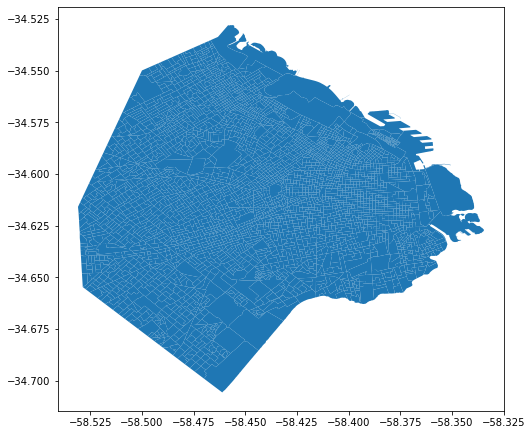

In [39]:
f,ax = plt.subplots(figsize=(8,8))

radios.to_crs(epsg=4326).plot(ax=ax)
parques_data.loc[parques_data.nombre.map(lambda n: 'Serrano' in n),:].buffer(0.005).plot(color='red',ax=ax)

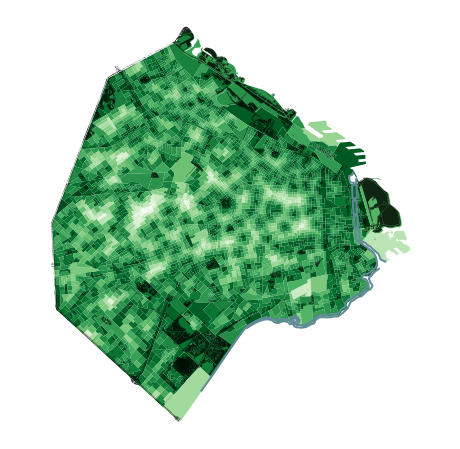

In [17]:
f, ax = plt.subplots(1,figsize=(8,8))
radios.plot(column='distancia',cmap='Greens_r', ax=ax)
parques.plot(color='black',alpha=0.8,ax=ax)
rios.plot(ax=ax, color='#618A98',linewidth=2)
plt.axis('equal')
ax.set_axis_off()
plt.show()
f.savefig('mapa_distancia_en_minutos.png')

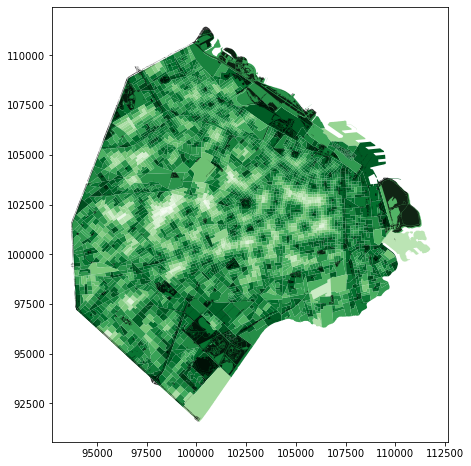

In [18]:
f, ax = plt.subplots(1,figsize=(8,8))
radios.plot(column='distancia',cmap='Greens_r', ax=ax)
parques.plot(color='black',alpha=0.8,ax=ax)


In [ ]:
#mplleaflet.show(fig=ax.figure, crs=radios.crs, tiles='cartodb_positron', path='mapa_radios.html')


# Cambio de unidades espaciales

Con los darios censales podemos generar medidas resumen para cada comuna. Pero si queremos utilizar otras unidades espaciales como por ejemplo barrios, debemos saber a que barrio pertenece cada radio.

In [ ]:
barrios = gpd.read_file('data/barrios_badata.shp')
barrios.crs

In [ ]:
radios.crs

In [ ]:
radios.crs == barrios.crs

In [ ]:
barrios = barrios.to_crs(radios.crs)
radios.crs == barrios.crs

In [ ]:
#spatial join entre poligonos y puntos
radios_p = gpd.sjoin(radios_p,barrios,how="left", op='intersects')
radios_p.head()

In [ ]:
#SIGUE DANDO MAL
radios_p.BARRIO.isnull().sum()

In [ ]:
#vemos los que no tienen barrio
radios_p.loc[radios_p.BARRIO.isnull(),]

In [ ]:
#un poco de limpieza para leer mejor
radios_p = radios_p.reindex(columns = ['CO_FRAC_RA', 'COMUNA_left', 'TOTAL_POB', 'densidad', 'geometry',
       'distancia', 'BARRIO'])
radios_p.columns =  ['CO_FRAC_RA', 'COMUNA', 'TOTAL_POB', 'densidad', 'geometry',
       'distancia', 'BARRIO']
radios_p.head()

In [ ]:
#lleno los nan para visualizar
radios_p.BARRIO = radios_p.BARRIO.fillna('vacio')

In [ ]:
#ploteo comuna 1 para ver que puede estar pasando
f, ax = plt.subplots(1,figsize=(8,8))
barrios.loc[barrios.COMUNA == 1,:].plot(ax=ax,column='BARRIO',cmap='Set2', legend = True)
radios_p.loc[radios_p.COMUNA == 1,:].plot(ax=ax,column='BARRIO',cmap='Set1', legend = True)
plt.axis('equal')
ax.set_axis_off()

In [ ]:
radios_p.BARRIO = radios_p.BARRIO.replace({'vacio':'PUERTO MADERO'})

In [ ]:
barrios.loc[barrios.BARRIO == 'PUERTO MADERO','geometry'].item()

In [ ]:
list(barrios.loc[barrios.BARRIO == 'PUERTO MADERO','geometry'].item().interiors)

In [ ]:
from shapely.geometry import Polygon
pol = barrios.loc[barrios.BARRIO == 'PUERTO MADERO','geometry'].copy().item()
pol = Polygon(pol.exterior.coords)
pol

In [ ]:
radios_p.head()

In [ ]:
f, ax = plt.subplots(1,figsize=(8,8))
barrios.loc[barrios.COMUNA == 1,:].plot(ax=ax,column='BARRIO',cmap='Set2', legend = True)
radios_p.loc[radios_p.COMUNA == 1,:].plot(ax=ax,column='BARRIO',cmap='Set1', legend = True)
plt.axis('equal')
ax.set_axis_off()

## Obtener estadisticos

In [ ]:
radios.head()

In [ ]:
#obtenemos un promedio simple
promedio_simple = radios_p.loc[:,['BARRIO','distancia']].groupby('BARRIO').mean().reset_index()
promedio_simple.head()

In [ ]:
#pasamos estos datos a la cartografia
promedio_simple = barrios.merge(promedio_simple,on='BARRIO')
promedio_simple = promedio_simple.sort_values(by='distancia')
promedio_simple.head()

In [ ]:
f, ax = plt.subplots(1,figsize=(8,8))
promedio_simple.plot(column='distancia',cmap='Greens_r',ax=ax,legend=True)
plt.axis('equal')
ax.set_axis_off()

In [ ]:
def promedio_ponder(dt):
    return np.average(dt.distancia, weights=dt.TOTAL_POB)

In [ ]:
#obtenemos un promedio ponderado

promedio_poderado = radios_p.loc[:,['BARRIO','TOTAL_POB','distancia']].groupby('BARRIO').agg(promedio_ponder)
promedio_poderado = promedio_poderado.drop('TOTAL_POB',axis=1)
promedio_poderado = promedio_poderado.sort_values(by='distancia')
promedio_poderado.head()

In [ ]:
dt = pd.DataFrame({'BARRIO':['A','A','B','B'],
                  'distancia':[0,2,10,20],
                   'TOTAL_POB':[0,2,100,2]})

In [ ]:
dt.groupby('BARRIO').agg(np.mean)

In [ ]:
dt.groupby('BARRIO').agg(promedio_ponder)

In [ ]:
#pasamos estos datos a la cartografia
promedio_poderado = barrios.merge(promedio_poderado,on='BARRIO')
promedio_poderado = promedio_poderado.sort_values(by='distancia')
promedio_poderado.head()

In [ ]:
f, ax = plt.subplots(1,figsize=(8,8))
promedio_poderado.plot(column='distancia',cmap='Greens_r',ax=ax,legend=True)
plt.axis('equal')
ax.set_axis_off()